In [ ]:
!jt -t solarizedl

In [1]:
import sys; print(sys.version)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.style.use('seaborn-darkgrid')
shap.initjs()

from sklearn import preprocessing, metrics


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


import time

%matplotlib inline

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [ ]:
m_D = pd.read_pickle('/Users/liamisaacs/Desktop/github repositories/personalwebsite/data/match_data_version1.pickle')
w_D =  pd.read_pickle('/Users/liamisaacs/Desktop/github repositories/personalwebsite/data/match_winner_data_version1.pickle')
#l_D = pd.read_pickle('/Users/liamisaacs/Desktop/github repositories/personalwebsite/data/match_loser_data_version1.pickle')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [ ]:
#separate target variable from dataframe
df2 = pd.merge(m_D,w_D,on='gameId',how='left')

In [ ]:
df2

In [ ]:
df_d1 = df2

In [ ]:
df_d1.drop(columns=['gameType','mapId', 'platformId','seasonId','status.message',
                    'status.status_code','vilemawKills','dominionVictoryScore'], inplace=True)

In [ ]:
static_summonerspell_list = watcher.data_dragon.summoner_spells(latest, 'en_US')
summonerspell_dict = {}
for key in static_summonerspell_list['data']:
    row = static_summonerspell_list['data'][key]
    summonerspell_dict[row['key']] = row['id']

In [ ]:
df_d1

In [ ]:
_pre_df = pd.DataFrame()
# B = Blue team (teamId == 100); R = Red Team (teamId == 200)
roledict = {
    #avoid autofills, only analyze ppl queing for that role
    'top': {'role': 'TOP'},
    'jg': {'role': 'JUNGLE'},
    'mid': {'role': 'MIDDLE'},
    'adc': {'role': 'BOTTOM'},
    'supp': {'role': 'UTILITY'}
}

summonerspells = ['spell1Id', 'spell2Id']
teams = {'B':'100','R':'200'}
for team, j in teams.items(): #for B, for R
    for key, value in roledict.items():
        _pre_df[str(key)+'_'+str(team)] = df_d1['participants'].map(lambda x: ', '.join(
             #join in champ name
             champ_name_dict[str(i['championId'])]
            
             #for each row
             for i in x
             #only if you're whichever role
             #on whichever team
             if str(list(champion_roles[i['championId']].keys())[0]) == value['role']
             and
             str(i['teamId']) == teams.get(team)
             )                                                                       
        )
        #write summoner spells per role
        for spell in range(0,len(summonerspells)):
            colname = str(key)+'_'+str(summonerspells[spell])+'_'+str(team)
            _pre_df[colname] = df_d1['participants'].map(lambda x: ' '.join(
                str(i[summonerspells[spell]])
                for i in x
                 if str(list(champion_roles[i['championId']].keys())[0]) == value['role']
                 and
                 str(i['teamId']) == teams.get(team)
                 )                                    
       )
#add np.nan instead of ' ' for columns that are blank - indicative that they do not 
#fulfill the if statements above 


In [ ]:
col = ['supp_B', 'adc_B', 'mid_B', 'jg_B', 'top_B', 'supp_R', 'adc_R', 'mid_R','jg_R','top_R']
for i in col:
    _pre_df[i].replace('', np.nan, inplace=True)

In [ ]:
#add teamId of who won
_pre_df['W'] = df_d1['participants'].map(lambda x: ' '.join(
                                        str(i['teamId'])
                                        for i in x
                                        if str(i['stats']['win']) == 'True'
))
#since the above will add 100 100 100 100 100, when we only want 100, we do
_pre_df['W'] = _pre_df['W'].astype(str).str[0:3]

In [ ]:
_pre_df

In [ ]:
_ppre_df = _pre_df

In [ ]:
_ppre_df = _ppre_df.dropna(subset=['supp_B', 'adc_B', 'mid_B', 'jg_B', 'top_B', 'supp_R', 'adc_R', 'mid_R','jg_R','top_R'])

In [ ]:
_ppre_df.sample(10)

In [ ]:
_ppre_df

In [ ]:
x = ['supp_B', 'adc_B', 'mid_B', 'jg_B', 'top_B', 'supp_R', 'adc_R', 'mid_R','jg_R','top_R']
for col in x:
    one_hot = pd.get_dummies(_ppre_df[col], drop_first=True, prefix=col)
    _ppre_df.drop(col,axis = 1)
    _ppre_df = _ppre_df.join(one_hot)

_ppre_df

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [ ]:
gbt_ppre_df = _ppre_df
target = gbt_ppre_df['W']
gbt_ppre_df = gbt_ppre_df.drop(columns=['W', 'top_B', 'jg_B', 'mid_B', 'top_B', 'top_spell1Id_B', 'top_spell2Id_B',
                         'top_B', 'top_spell1Id_B', 'top_spell2Id_B',
                          'jg_B', 'jg_spell1Id_B', 'jg_spell2Id_B',
                          'mid_B', 'mid_spell1Id_B', 'mid_spell2Id_B',
                          'adc_B', 'adc_spell1Id_B', 'adc_spell2Id_B',
                          'supp_B', 'supp_spell1Id_B', 'supp_spell2Id_B',
                          'top_R', 'top_spell1Id_R', 'top_spell2Id_R',
                          'jg_R', 'jg_spell1Id_R', 'jg_spell2Id_R',
                          'mid_R', 'mid_spell1Id_R', 'mid_spell2Id_R', 
                          'adc_R', 'adc_spell1Id_R', 'adc_spell2Id_R', 
                          'supp_R', 'supp_spell1Id_R', 'supp_spell2Id_R'
                         ])
gbt_ppre_df

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(gbt_ppre_df, 
#                                                     target, 
#                                                     random_state=42, 
#                                                     test_size=0.1)


In [ ]:
# sc = StandardScaler()
# X_train_std = sc.fit_transform(X_train)
# X_test_std = sc.transform(X_test)

# gbr_params = {'n_estimators': 1000,
#           'max_depth': 3,
#           'min_samples_split': 5,
#           'learning_rate': 0.01,
#           'loss': 'ls'}

# gbr = GradientBoostingRegressor(**gbr_params)

# gbr.fit(X_train_std, y_train)

# print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))

# mse = mean_squared_error(y_test, gbr.predict(X_test_std))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(gbt_ppre_df)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(gbr, X_test_std, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

Pregame data was an absolute failure. Moving on to post-game analysis

In [ ]:
df_d2 = df_d1.copy()
df_d2 = df_d2[df_d2['queueId'] == 420]

In [ ]:
_post_df = pd.DataFrame()

In [ ]:
j = ['kills', 
     'deaths', 'assists', 'largestKillingSpree', 'largestMultiKill', 'killingSprees', 
     'longestTimeSpentLiving', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills', 
     'totalDamageDealt', 'magicDamageDealt', 'physicalDamageDealt', 'trueDamageDealt', 
     'largestCriticalStrike', 'totalDamageDealtToChampions', 'magicDamageDealtToChampions', 
     'physicalDamageDealtToChampions', 'trueDamageDealtToChampions', 'totalHeal', 
     'totalUnitsHealed', 'damageSelfMitigated', 'damageDealtToObjectives', 'damageDealtToTurrets',
     'visionScore', 'timeCCingOthers', 'totalDamageTaken', 'magicalDamageTaken', 
     'physicalDamageTaken', 'trueDamageTaken', 'goldEarned', 'goldSpent', 'turretKills', 
     'inhibitorKills', 'totalMinionsKilled', 'neutralMinionsKilled', 'neutralMinionsKilledTeamJungle',
     'neutralMinionsKilledEnemyJungle', 'totalTimeCrowdControlDealt', 'champLevel', 
     'visionWardsBoughtInGame', 'wardsPlaced', 'wardsKilled', 
     'firstBloodKill', 'firstBloodAssist', 'firstTowerKill', 'firstTowerAssist', 
     'firstInhibitorKill', 'firstInhibitorAssist']
for col in j:
    _post_df[col] = df_d2['participants'].map(lambda x:
          ''.join(str(i['stats'][col]) for i in x  if i['participantId'] == 1 and col in i['stats']
                  )
                )

In [ ]:
_post_df

In [ ]:
_df = _post_df.copy()

In [ ]:
#add in win
_df['win'] = df_d2['participants'].map(lambda x:
                                          ' '.join(str(i['stats']['win']) for i in x
                                                      if i['participantId'] == 1 
                                                      ))

In [ ]:
#merge in game duration (so we can use rates)
game_dur = df_d1['gameDuration'] #game_dur is a pandas Series
_df = pd.concat([_post_df, game_dur], axis=1)
_df.dropna(inplace=True)

In [ ]:
#replace True/False with 1/0
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist']
for col in t_f_col:
    _df[col].replace({'False': False, 'True': True}, inplace=True)
for col in binary_t_f_col:
    _df[col].replace({'False': 0, 'True': 1}, inplace=True)

In [ ]:
#sometimes blank, fill w/ 0 (assume they are supposed to be 'False')
convert = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist']
for col in convert:
    _df[col].replace('', np.nan, inplace=True)
    _df[col].fillna(False, inplace=True)


In [ ]:
df = _df.copy()

In [185]:
df
liamgg_data = df.to_csv('liamgg_data.csv', index = True) 

In [2]:
df = pd.read_csv('/Users/liamisaacs/Desktop/github repositories/personalwebsite/data/liamgg_data.csv')
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist']
for col in t_f_col:
    df[col].replace({'False': False, 'True': True}, inplace=True)
for col in binary_t_f_col:
    df[col].replace({'False': 0, 'True': 1}, inplace=True)

In [3]:
X_ = df.drop(["win"], axis=1)
y_ = df["win"]

#Convert all columns to numbers
for col in list(X_.columns):
    X_[col] = pd.to_numeric(X_[col])

In [4]:
X_

,Unnamed: 0,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,...,visionWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist,gameDuration
0,0,3,6,3,2,1,1,564,0,0,...,3,6,1,1.0,0.0,0.0,0.0,0.0,0.0,1323.0
1,1,3,5,2,2,1,1,351,0,0,...,4,11,1,0.0,0.0,0.0,0.0,0.0,0.0,1317.0
2,2,0,4,1,0,0,0,354,0,0,...,2,9,1,0.0,0.0,0.0,0.0,0.0,0.0,932.0
3,3,4,9,11,2,1,1,457,0,0,...,11,58,9,0.0,0.0,0.0,0.0,0.0,0.0,2098.0
4,4,7,12,12,2,1,1,377,0,0,...,1,9,8,1.0,0.0,0.0,0.0,0.0,0.0,2344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78167,108931,3,4,2,2,1,1,486,0,0,...,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,934.0
78168,108932,3,0,8,3,1,1,0,0,0,...,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,1418.0
78169,108933,0,2,8,0,0,0,270,0,0,...,3,10,2,0.0,0.0,0.0,0.0,0.0,1.0,933.0
78170,108937,0,4,3,0,0,0,510,0,0,...,1,9,1,0.0,0.0,0.0,0.0,0.0,0.0,1544.0


In [5]:
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills", 
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "timeCCingOthers", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame", 
    "wardsPlaced", "wardsKilled"
]

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    X_[feature_name] /= X_["gameDuration"] / 60 # per minute rate
    
X_["longestTimeSpentLiving"] /= X_["gameDuration"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in X_.columns]
X_.columns = feature_names

In [6]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(X_,y_, test_size=0.2, random_state=10)

In [7]:
#Check null values
Xt.isnull().values.any()

False

In [8]:
Xt.sample(10)

,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,largestKillingSpree,largestMultiKill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,...,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist,gameDuration
17687,22201,0.166976,0.000000,0.333952,3,1,0.055659,0.996289,0.000000,0.000000,...,0.166976,0.389610,0.222635,0.0,0.0,0.0,0.0,0.0,1.0,1078.0
17962,22525,0.104257,0.052129,0.260643,2,1,0.052129,0.447437,0.000000,0.000000,...,0.156386,0.469157,0.156386,0.0,0.0,0.0,0.0,0.0,0.0,1151.0
33802,45644,0.109223,0.072816,0.109223,3,1,0.036408,0.616505,0.000000,0.000000,...,0.145631,0.291262,0.036408,0.0,0.0,0.0,0.0,0.0,0.0,1648.0
6085,7357,0.051813,0.155440,0.051813,0,1,0.000000,0.493092,0.000000,0.000000,...,0.155440,0.984456,0.362694,0.0,0.0,0.0,0.0,0.0,0.0,1158.0
67382,93894,0.381255,0.190627,0.238284,3,2,0.142971,0.244639,0.095314,0.000000,...,0.238284,0.476569,0.047657,1.0,0.0,1.0,0.0,0.0,0.0,1259.0
48743,67408,0.129496,0.345324,0.258993,0,1,0.000000,0.224460,0.000000,0.000000,...,0.086331,0.345324,0.172662,0.0,0.0,0.0,0.0,0.0,1.0,1390.0
56723,78698,0.407156,0.074028,0.148057,8,3,0.074028,0.466996,0.037014,0.037014,...,0.185071,0.407156,0.185071,0.0,0.0,0.0,0.0,0.0,0.0,1621.0
33833,45683,0.327154,0.196292,0.196292,4,3,0.065431,0.403490,0.065431,0.065431,...,0.196292,0.458015,0.130862,0.0,0.0,0.0,1.0,0.0,0.0,917.0
54580,75693,0.000000,0.279330,0.111732,0,0,0.000000,0.302607,0.000000,0.000000,...,0.055866,0.279330,0.055866,0.0,0.0,0.0,0.0,0.0,0.0,1074.0
17641,22155,0.000000,0.363196,0.217918,0,0,0.000000,0.481840,0.000000,0.000000,...,0.072639,0.363196,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,826.0


In [9]:
print("# of observations in X_train dataset: ",Xt.shape)
print("# of observations in y_train dataset: ",yt.shape)
print("# of observations in X_val dataset: ", Xv.shape)
print("# of observations in y_val dataset: ", yv.shape)

# of observations in X_train dataset:  (62537, 52)
# of observations in y_train dataset:  (62537,)
# of observations in X_val dataset:  (15635, 52)
# of observations in y_val dataset:  (15635,)


### RF Classifier

Hypertune RF model

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from timeit import default_timer as timer

In [ ]:

rf = RandomForestClassifier()

#use grid search to find best parameters
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]   
}

cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(Xt,yt.values.ravel())

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
display(cv)

Run RF model with best hyperparameters

In [12]:
#run model
ntrees = 250
rf = RandomForestClassifier(n_estimators=ntrees, 
                            n_jobs=-1,
                            max_depth=None
                           )
start = timer()
rf.fit(Xt, yt)
stop = timer()
print(f"RF fit time with {len(Xt)} records and {ntrees} trees = {(stop-start):.2f}s")

RF fit time with 62537 records and 250 trees = 12.42s


In [ ]:
rf

In [ ]:
rf_cv_score = cross_val_score(rf, Xt, yt, cv=10)

In [13]:
y_pred = rf.predict(Xv)
cnf_matrix = confusion_matrix(yv, y_pred)
print("=== CONFUSION MATRIX ===")
print(cnf_matrix)
print('\n')

print("=== CLASSIFICATION REPORT === ")
print(classification_report(yv, y_pred))
print('\n')
print("=== All AUC Scores ===")
#print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== CONFUSION MATRIX ===
[[7067  840]
 [ 725 7003]]


=== CLASSIFICATION REPORT === 
              precision    recall  f1-score   support

       False       0.91      0.89      0.90      7907
        True       0.89      0.91      0.90      7728

    accuracy                           0.90     15635
   macro avg       0.90      0.90      0.90     15635
weighted avg       0.90      0.90      0.90     15635



=== All AUC Scores ===


=== Mean AUC Score ===


NameError: name 'rf_cv_score' is not defined

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [39]:
categories = ['True Loss','False Win','False Loss','True Win']
labels = np.asarray(labels).reshape(2,2)
make_confusion_matrix(cnf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

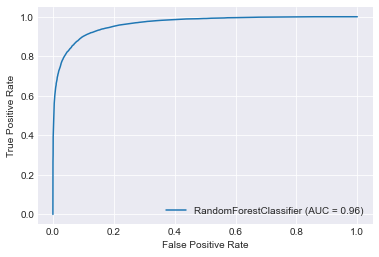

In [14]:
metrics.plot_roc_curve(rf, Xv, yv)  
plt.show()                                   

In [ ]:
#get SHAP values to use to interpret/debug model
Xv_ = Xv
Xt_ = Xt
start = timer()
explainer = shap.TreeExplainer(rf, Xt_, feature_perturbation="interventional")
shap_values = explainer.shap_values(Xv_)
stop = timer()

In [ ]:
shap.summary_plot(shap_values, Xv)

## XGBoost Classifier

In [ ]:
#for XGBoost (win must be 0 or 1)
Xt_boost = Xt
Xv_boost = Xv
#I regret adding these, they are not helpful
Xt_boost.drop(['firstInhibitorAssist', 'champLevel', 'largestCriticalStrike', 'damageSelfMitigated'], axis=1, inplace=True)
Xv_boost.drop(['firstInhibitorAssist', 'champLevel', 'largestCriticalStrike', 'damageSelfMitigated'], axis=1, inplace=True)

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)

In [ ]:
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:-1], Xv.iloc[0,:-1])

In [ ]:
shap.summary_plot(shap_values, Xv)

Bayesian optimization of XGBoost hyperparameters

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( Xt, yt), ( Xv, yv)]
    
    clf.fit(Xt, yt,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(Xv)
    accuracy = accuracy_score(yv, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
#trail-test a bunch of hyperparameters
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [12]:
#for XGBoost (win must be 0 or 1)
Xt_boost = Xt
Xv_boost = Xv
#I regret adding these, they are not helpful
Xt_boost.drop(['firstInhibitorAssist', 'champLevel', 'largestCriticalStrike', 'damageSelfMitigated'], axis=1, inplace=True)
Xv_boost.drop(['firstInhibitorAssist', 'champLevel', 'largestCriticalStrike', 'damageSelfMitigated'], axis=1, inplace=True)

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
params = {
    "eta": 0.5,
    "max_depth": 8,
    'min_child_weight': 1,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    'colsample_bytree': 0.7434869381604485, 
    'gamma': 1.1053886968419446,
    'reg_alpha': 49.0, 
    'reg_lambda': 0.9997899615065826
}
tuned_model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

[23:46:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.49100	valid-logloss:0.49594
[34]	train-logloss:0.20253	valid-logloss:0.23714


In [14]:
explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(Xv_boost)

In [15]:
shap.force_plot(explainer.expected_value, shap_values[0,:-1], Xv_boost.iloc[0,:-1])

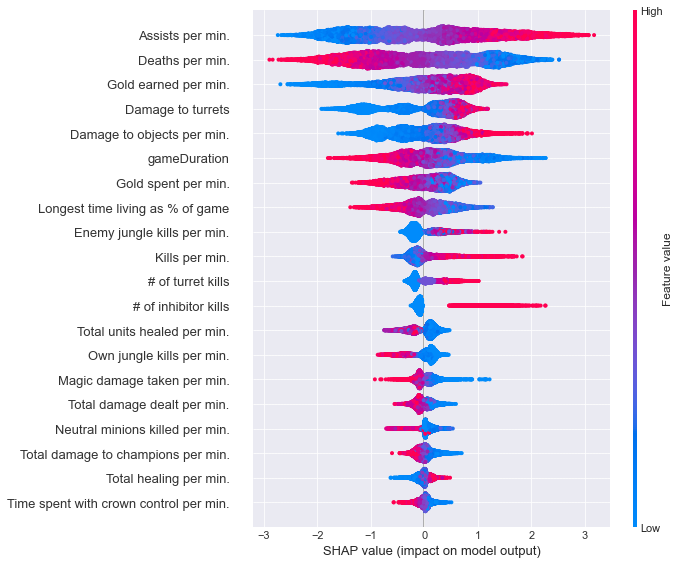

In [16]:
shap.summary_plot(shap_values, Xv_boost)

In [17]:
xs = np.linspace(-4,4,100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1/(1+np.exp(-xs)))
pl.show()

NameError: name 'pl' is not defined

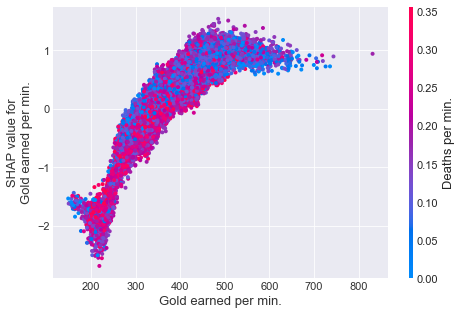

In [18]:
shap.dependence_plot("Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min.")

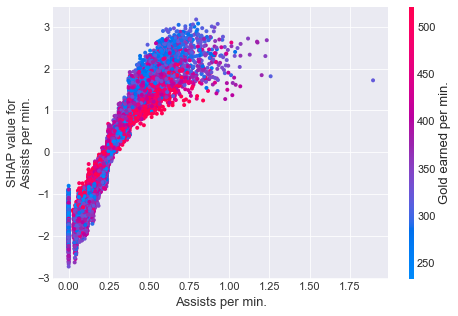

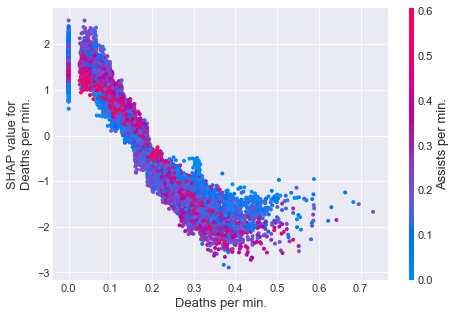

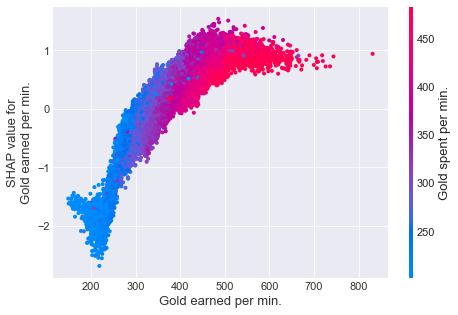

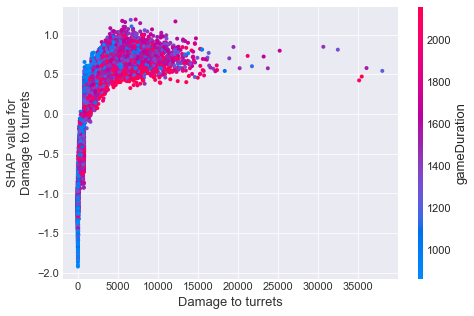

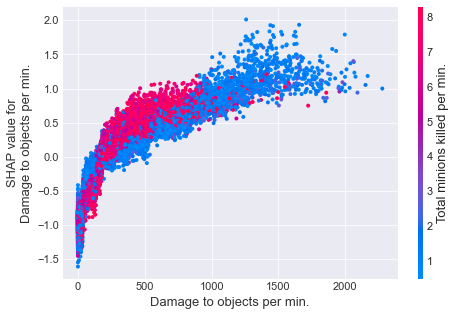

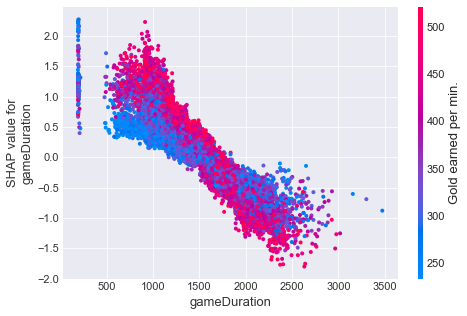

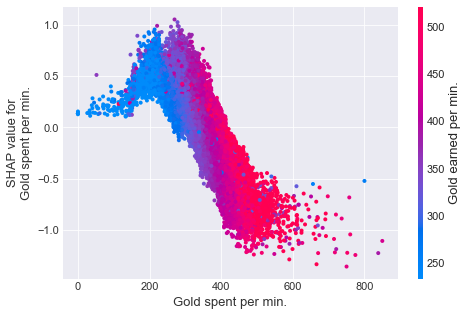

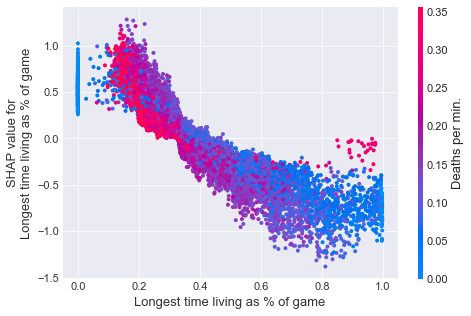

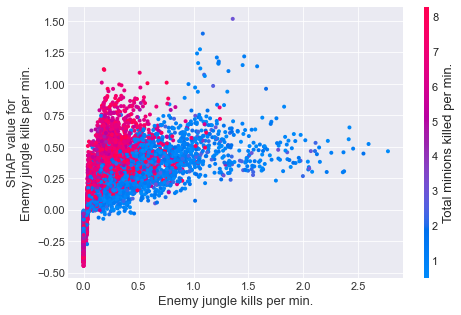

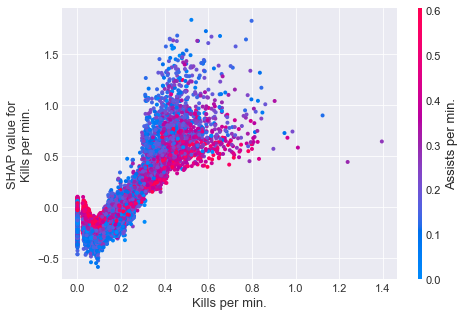

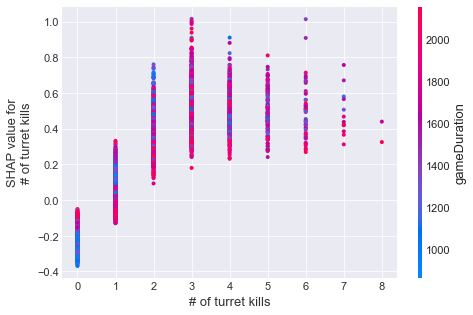

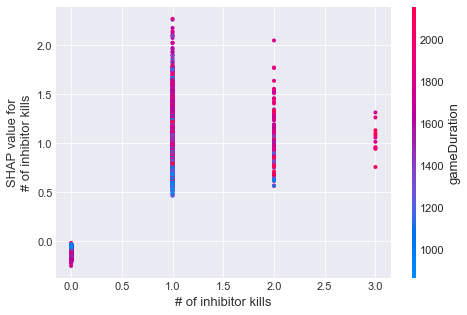

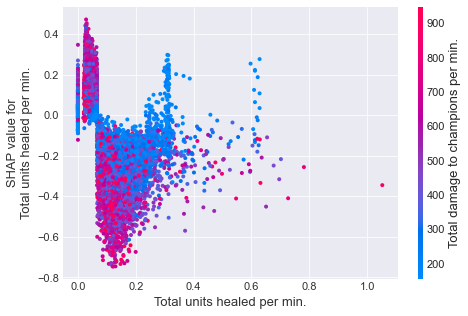

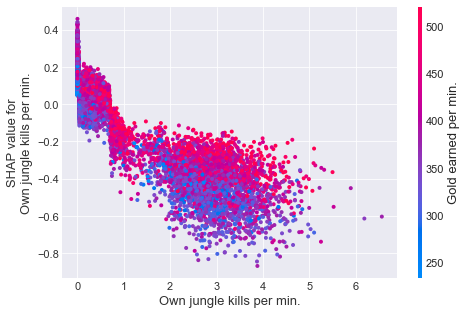

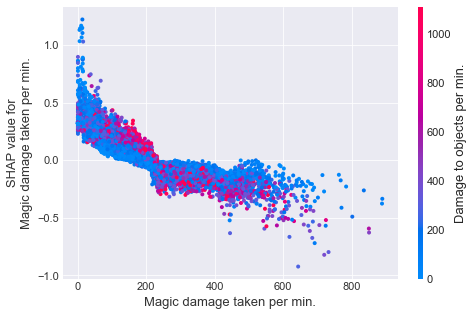

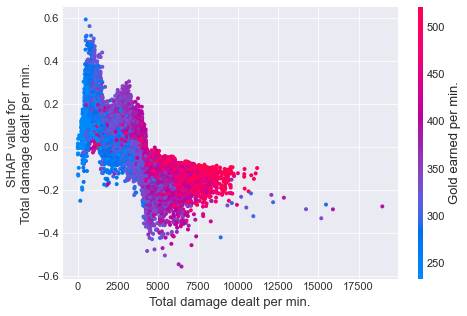

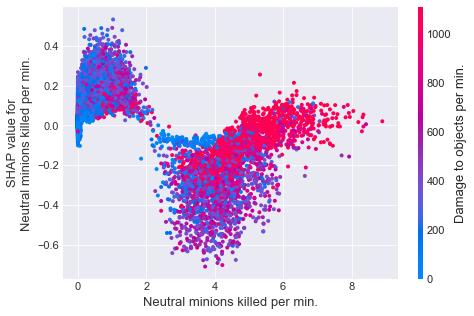

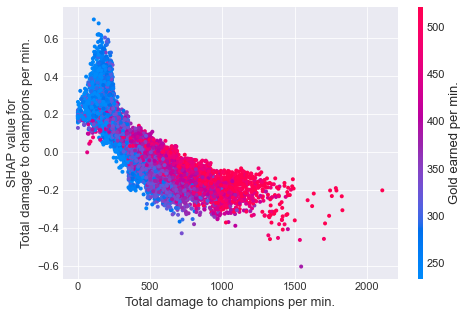

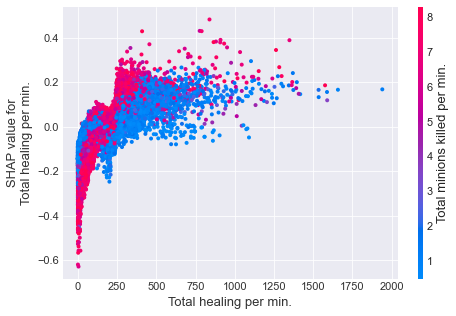

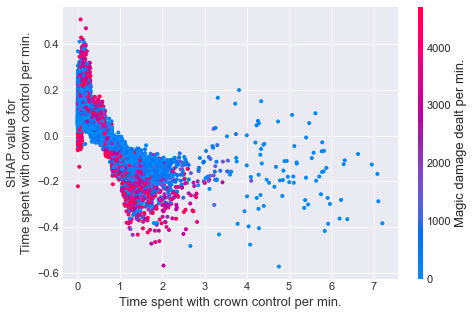

In [19]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)

In [232]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import numpy as np
import pprint
from datetime import datetime


# Fetching game data

class game_info_by_match_id():
    """
    Returns df of user info from a given match (so far).
    """
    #define private variables to use in class

    def __init__(self, api_key, name, region, gamemode, gameid):
        #upon calling the class we pass in a bunch of things to initialize^
        self.api_key = api_key
        self.name = name
        self.region = region
        self.gamemode = gamemode
        self.gameid = gameid
        watcher = LolWatcher(self.api_key)
        self.user = watcher.summoner.by_name(region, name)

    def rank_stats(self):
        watcher = LolWatcher(self.api_key)

        #league, division, games played, etc.
        encrypted_summoner_id = self.user['id']
        self.rank_stats = watcher.league.by_summoner(self.region, self.user['id'])
        return self.rank_stats

    def match_data(self):
        watcher = LolWatcher(self.api_key)

        self.matches = watcher.match.matchlist_by_account(self.region, self.user['accountId'])

        self.match_data = watcher.match.by_id(self.region, self.gameid)
        m = self.match_data

        #n is for each "participant" or player in the match
        def gd():
            n = [] #dump raw stats into here from participants
            for row in m['participants']:
                m_row = {}
                m_row['champion'] = row['championId']
                m_row['spell1'] = row['spell1Id']
                m_row['spell2'] = row['spell2Id']
                m_row['teamId'] = row['teamId']
                win_lose = row['stats']['win']
                if win_lose == True:
                    win_lose = '胜利'
                else:
                    win_lose = '失败'
                m_row['win'] = win_lose
                m_row['kills'] = row['stats']['kills']
                m_row['deaths'] = row['stats']['deaths']
                m_row['assists'] = row['stats']['assists']
                m_row['totalDamageDealt'] = row['stats']['totalDamageDealt']
                m_row['totalDamageDealtToChampions'] = row['stats']['totalDamageDealtToChampions']
                m_row['goldEarned'] = row['stats']['goldEarned']
                m_row['champLevel'] = row['stats']['champLevel']
                m_row['totalMinionsKilled'] = row['stats']['totalMinionsKilled']
                m_row['largestKillingSpree'] = row['stats']['largestKillingSpree']
                m_row['largestMultiKill'] = row['stats']['largestMultiKill']
                m_row['item0'] = row['stats']['item0']
                m_row['item1'] = row['stats']['item1']
                m_row['item2'] = row['stats']['item2']
                m_row['item3'] = row['stats']['item3']
                m_row['item4'] = row['stats']['item4']
                m_row['item5'] = row['stats']['item5']
                m_row['item6'] = row['stats']['item6']
                m_row['firstBloodKill'] = row['stats']['firstBloodKill']
                m_row['firstBloodAssist'] = row['stats']['firstBloodAssist']
                m_row['visionWardsBoughtInGame'] = row['stats']['visionWardsBoughtInGame']
                m_row['visionScore'] = row['stats']['visionScore']
                m_row['creepsPerMinDeltas'] = row['timeline']['creepsPerMinDeltas']
                m_row['goldPerMinDeltas'] = row['timeline']['goldPerMinDeltas']
                m_row['lane'] = row['timeline']['lane']
                m_row['ccScore'] = row['stats']['totalTimeCrowdControlDealt']
                m_row['perkPrimaryStyle'] = row['stats']['perkPrimaryStyle']
                m_row['perkSubStyle'] = row['stats']['perkSubStyle']
                m_row['killingSprees'] = row['stats']['killingSprees']
                m_row['longestTimeSpentLiving'] = row['stats']['longestTimeSpentLiving']
                m_row['doubleKills'] = row['stats']['doubleKills']
                m_row['tripleKills'] = row['stats']['tripleKills']
                m_row['quadraKills'] = row['stats']['quadraKills']
                m_row['pentaKills'] = row['stats']['pentaKills']                
                m_row['magicDamageDealtToChampions'] = row['stats']['magicDamageDealtToChampions']
                m_row['physicalDamageDealtToChampions'] = row['stats']['physicalDamageDealtToChampions']
                m_row['physicalDamageDealtToChampions'] = row['stats']['physicalDamageDealtToChampions']
                m_row['trueDamageDealtToChampions'] = row['stats']['trueDamageDealtToChampions']
                m_row['totalHeal'] = row['stats']['totalHeal']
                m_row['totalUnitsHealed'] = row['stats']['totalUnitsHealed']
                m_row['damageDealtToObjectives'] = row['stats']['damageDealtToObjectives']
                m_row['damageDealtToTurrets'] = row['stats']['damageDealtToTurrets']
                m_row['totalDamageTaken'] = row['stats']['totalDamageTaken']
                m_row['magicalDamageTaken'] = row['stats']['magicalDamageTaken']
                m_row['physicalDamageTaken'] = row['stats']['physicalDamageTaken']
                m_row['trueDamageTaken'] = row['stats']['trueDamageTaken']
                m_row['turretKills'] = row['stats']['turretKills']
                m_row['inhibitorKills'] = row['stats']['inhibitorKills']
                m_row['firstTowerKill'] = row['stats']['firstTowerKill']
                m_row['firstTowerAssist'] = row['stats']['firstTowerAssist']
                m_row['totalDamageDealt'] = row['stats']['totalDamageDealt']
                m_row['physicalDamageDealt'] = row['stats']['physicalDamageDealt']
                m_row['trueDamageDealt'] = row['stats']['trueDamageDealt']
                m_row['magicDamageDealt'] = row['stats']['magicDamageDealt']
                m_row['goldSpent'] = row['stats']['goldSpent']
                m_row['neutralMinionsKilled'] = row['stats']['neutralMinionsKilled']
                m_row['neutralMinionsKilledTeamJungle'] = row['stats']['neutralMinionsKilledTeamJungle']
                m_row['neutralMinionsKilledEnemyJungle'] = row['stats']['neutralMinionsKilledEnemyJungle']
                m_row['totalTimeCrowdControlDealt'] = row['stats']['totalTimeCrowdControlDealt']
                m_row['wardsPlaced'] = row['stats']['wardsPlaced']
                m_row['wardsKilled'] = row['stats']['wardsKilled']   
                n.append(m_row)
            return n

        n = gd()
        for i in range(0,len(n)):
            n[i]['summonerName'] = m['participantIdentities'][i]['player']['summonerName']
            n[i]['profileIcon'] = m['participantIdentities'][i]['player']['profileIcon']

        latest = watcher.data_dragon.versions_for_region(self.region)['n']['champion']
        static_champ_list = watcher.data_dragon.champions(latest, False, 'en_US')
        static_item_list = watcher.data_dragon.items(latest, 'en_US')
        static_summonerspell_list = watcher.data_dragon.summoner_spells(latest, 'en_US')

        def g_c(n): #gets summoner spells, champions, and items

            #summoner spells
            spell_url = "http://ddragon.leagueoflegends.com/cdn/11.2.1/img/spell/"

            summonerspell_dict = {}
            for key in static_summonerspell_list['data']:
                row = static_summonerspell_list['data'][key]
                summonerspell_dict[row['key']] = row['id']
                summonerspell_dict[row['key']] = spell_url + str(row['image']['full'])

            #champs
            champ_url = "https://ddragon.leagueoflegends.com/cdn/11.2.1/img/champion/"

            champ_name_dict = {}
            champ_image_dict = {}
            for key in static_champ_list['data']:
                row = static_champ_list['data'][key]
                champ_name_dict[row['key']] = row['id']
               # champ_dict[row['image']] = champ_url + str(row['image']['full'])
                champ_image_dict[row['key']] = champ_url +  str(row['image']['full'])

            #items
            item_url = "https://ddragon.leagueoflegends.com/cdn/11.2.1/img/item/"

            item_dict = {}

            for key in static_item_list['data']:
                row = static_item_list['data'][key]
                item_dict[key] = row['name']
            #add to df
            for row in n:
                #print(str(row['item1']) + ' ' + item_dict[str(row['item1'])])
                row['championName'] = champ_name_dict[str(row['champion'])]
                row['championImage'] = champ_image_dict[str(row['champion'])]
                for i in range(0,7):
                    try:
                        row['itemName' +str(i)] = item_dict[str(row['item'+str(i)])]
                        row['itemImage' + str(i)] = item_url + str(row['item'+str(i)]) + '.png'
                    except:
                        row['itemName' +str(i)] = 0
                row['spell1Image'] = summonerspell_dict[str(row['spell1'])]
                row['spell2Image'] = summonerspell_dict[str(row['spell2'])]

                row['profileIconImage'] = 'http://ddragon.leagueoflegends.com/cdn/11.2.1/img/profileicon/' + str(row['profileIcon']) + '.png'

            df = pd.DataFrame(n)

            if self.name == 'Divine Right':
                df['MVP'] = 'MVP'
            else:
                df['MVP'] = ''

            return df

        df = g_c(n)
        #add in extra columns
        df['gameDur'] = m['gameDuration']
        df['gameDuration'] = round((m['gameDuration'] / 60),2)
        df['gameMode'] = m['gameMode']
        df['gameCreation'] = m['gameCreation'] / 1000
        df['kda'] = ((df['kills'] + df['assists']) / df['deaths']).round(2)
        df['killParticipation'] = ((df['kills'] + df['assists'])/ df.groupby('teamId')['kills'].transform(np.sum) * 100).astype(int)
        df['minionsKilledPerMinute'] = (df['totalMinionsKilled'] / df['gameDuration']).round(1)
        df['teamTotalKills'] = df['teamId'].apply(lambda x: df['kills'].groupby(df['teamId']).sum().values[0] if x == 100 else df['kills'].groupby(df['teamId']).sum().values[1])        #get time since last played (in days)
        df['teamTotalGold'] = df['teamId'].apply(lambda x: df['goldEarned'].groupby(df['teamId']).sum().values[0] if x == 100 else df['goldEarned'].groupby(df['teamId']).sum().values[1])
        df['teamTotalDamage'] = df['teamId'].apply(lambda x: df['totalDamageDealtToChampions'].groupby(df['teamId']).sum().values[0] if x == 100 else df['totalDamageDealtToChampions'].groupby(df['teamId']).sum().values[1])
        df['playerDamageAsFractionOfTeamDamage'] = df['totalDamageDealtToChampions'] / df['teamTotalDamage']
        df['playerDamageAsFractionOfTeamDamage'] = round(df['playerDamageAsFractionOfTeamDamage'],2)*100

        df.loc[(df.kda == np.inf), 'kda'] = 'BEAST-MODE'

        #get time since last played (in days)

        now = datetime.now()
        last_game_played_when = df['gameCreation'].values[0]
        last_game_played_when = datetime.fromtimestamp(last_game_played_when)

        df['lastGamePlayedWhen'] = (now - last_game_played_when).days

        #get first blood, baron kills, etc.
        def g_t(df, m):
            def x(y):
                m_id = m['teams'][0]['teamId']
                m_team = m['teams'][0]
                return np.where(df['teamId']==m_id, m_team[y], m['teams'][0+1][y])
            l = ['firstBlood', 'baronKills', 'firstTower', 'firstRiftHerald', 'towerKills',
                 'inhibitorKills', 'dragonKills','riftHeraldKills']
            for i in l:
                df[i] = x(i)
            return df, m

        def game_dur(x):
            x = str(x).split('.')
            return x[0] + ' m ' + x[1] + ' s'

        df['gameDuration'] = game_dur(df['gameDuration'].values[0])

        df, m = g_t(df, m)

        return df, m


In [255]:
api_key = 'RGAPI-a2d1e695-2000-4f49-afff-57606b210cab'
gamemode = 'CLASSIC'
region = 'na1'
watcher = LolWatcher(api_key)
name = 'Doublelift'

user = watcher.summoner.by_name('na1', name)
matches = watcher.match.matchlist_by_account(region, user['accountId'])
game_ids = []


for i in range(0,2): #display 10 games
    game_ids.append(matches['matches'][i]['gameId'])

gameid = game_ids[0]


df_game, m = game_info_by_match_id(api_key,
                                      name, region,
                                      gamemode, gameid).match_data()

In [256]:
df_game

,champion,spell1,spell2,teamId,win,kills,deaths,assists,totalDamageDealt,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,largestKillingSpree,largestMultiKill,item0,item1,item2,item3,item4,item5,item6,firstBloodKill,firstBloodAssist,visionWardsBoughtInGame,visionScore,creepsPerMinDeltas,goldPerMinDeltas,lane,ccScore,perkPrimaryStyle,perkSubStyle,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageDealtToObjectives,damageDealtToTurrets,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,turretKills,inhibitorKills,firstTowerKill,firstTowerAssist,physicalDamageDealt,trueDamageDealt,magicDamageDealt,goldSpent,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,wardsPlaced,wardsKilled,summonerName,profileIcon,championName,championImage,itemName0,itemImage0,itemName1,itemName2,itemImage2,itemName3,itemImage3,itemName4,itemImage4,itemName5,itemImage5,itemName6,itemImage6,spell1Image,spell2Image,profileIconImage,itemImage1,MVP,gameDur,gameDuration,gameMode,gameCreation,kda,killParticipation,minionsKilledPerMinute,teamTotalKills,teamTotalGold,teamTotalDamage,playerDamageAsFractionOfTeamDamage,lastGamePlayedWhen,firstBlood,baronKills,firstTower,firstRiftHerald,towerKills,dragonKills,riftHeraldKills
0,875,4,14,100,失败,1,7,5,21130,7921,6174,11,32,0,1,3857,0,6664,2031,3111,1028,3364,False,False,7,54,"{'10-20': 1.4, '0-10': 1.1}","{'10-20': 293.6, '0-10': 159.9}",BOTTOM,59,8200,8300,0,448,0,0,0,0,622,4135,3163,817,1,250,250,17943,8615,7632,1696,1,0,False,False,11111,8148,1871,5525,0,0,0,59,24,9,LIMlT,4249,Sett,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Pauldrons of Whiterock,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,Turbo Chemtank,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Refillable Potion,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Mercury's Treads,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Ruby Crystal,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Oracle Lens,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,NaN,,1588,26 m 47 s,CLASSIC,1.612940e+09,0.86,46,1.2,13,42928,60780,13.0,0,True,0,True,False,2,1,0
1,523,4,7,100,失败,2,6,5,136036,18230,10355,13,222,0,1,1055,6672,1037,3085,3006,0,3363,False,False,3,36,"{'10-20': 9.9, '0-10': 8.4}","{'10-20': 450.70000000000005, '0-10': 287.4}",BOTTOM,208,8000,8200,0,493,0,0,0,0,295,15753,2181,3589,3,2878,2878,14420,5310,8303,805,0,0,False,False,124274,8257,3503,8700,25,21,0,208,10,8,Doublelift,4568,Aphelios,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Doran's Blade,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Kraken Slayer,Pickaxe,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Runaan's Hurricane,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Berserker's Greaves,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,NaN,Farsight Alteration,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,https://ddragon.leagueoflegends.com/cdn/11.2.1...,,1588,26 m 47 s,CLASSIC,1.612940e+09,1.17,53,8.4,13,42928,60780,30.0,0,True,0,True,False,2,1,0
2,777,14,4,100,失败,3,5,4,119426,9868,9623,14,174,2,1,6673,3031,3111,1055,0,0,3340,False,False,4,15,"{'10-20': 7, '0-10': 6.5}","{'10-20': 326.2, '0-10': 289.4}",MIDDLE,103,8000,8100,1,637,0,0,0,0,1362,6732,1774,6136,1,2086,208,19314,10473,7707,1133,0,0,False,False,106698,1774,10953,8750,12,10,0,103,10,0,Light,4020,Yone,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Immortal Shieldbow,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Infinity Edge,Mercury's Treads,https://ddragon.le

In [257]:
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [258]:
Xv

,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,champLevel
64373,89616.0,0.108254,0.108254,0.351827,2,1,0.027064,0.396482,0.000000,0.000000,0.0,0.0,4697.916103,799.621110,3457.834912,440.433018,0.0,185.277402,0.450450,161.109608,0.202885,353.450609,0.027064,35192.0,1103.707713,844,46,0.378890,943.572395,290.906631,619.675237,32.936401,317.456022,286.197564,0,0,0.811908,3.653586,2.516915,0.027064,12.259811,0.324763,0.595399,0.135318,2217.0,NaN
43940,60486.0,0.000000,0.000000,0.609343,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,655.328368,321.408260,180.731212,153.148274,0.0,261.489506,8.579487,40.866622,0.382851,322.342586,0.203114,3654.0,87.786053,1737,62,0.568720,275.382532,94.082600,181.259309,0.000000,272.620176,246.784022,0,0,1.137441,0.000000,0.000000,0.000000,2.356127,0.365606,1.381178,0.324983,1477.0,NaN
42684,58678.0,0.117493,0.117493,0.509138,2,2,0.039164,0.570496,0.039164,0.000000,0.0,0.0,2576.592689,1976.945170,499.073107,100.574413,0.0,455.208877,15.054810,42.532637,1.107445,98.851175,0.039164,6470.0,195.861619,4279,27,0.469974,552.571802,259.660574,272.663185,20.208877,363.093995,333.877285,0,0,5.835509,0.313316,0.313316,0.000000,1.135770,0.195822,0.313316,0.234987,1532.0,NaN
50012,69168.0,0.164986,0.164986,0.164986,2,1,0.054995,0.298808,0.000000,0.000000,0.0,0.0,3145.517874,124.839597,2977.561870,43.116407,0.0,312.263978,2.189735,251.274060,1.161406,1.649863,0.054995,3231.0,62.034830,1128,16,0.329973,301.319890,71.219065,221.301558,8.799267,377.928506,343.721357,0,0,7.974335,0.000000,0.000000,0.000000,3.739688,0.000000,0.274977,0.329973,1091.0,NaN
51189,70859.0,0.171429,0.171429,0.128571,2,1,0.042857,0.283571,0.000000,0.000000,0.0,0.0,5574.985714,4952.014286,472.071429,150.857143,0.0,647.014286,25.343265,55.628571,0.000000,905.442857,0.042857,9569.0,179.228571,2512,14,0.128571,991.157143,260.142857,724.971429,6.000000,381.471429,310.714286,0,0,6.857143,0.814286,0.557143,0.171429,4.628571,0.085714,0.428571,0.000000,1400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62858,87463.0,0.185759,0.046440,0.557276,3,1,0.046440,0.125387,0.000000,0.000000,0.0,0.0,851.191950,567.585139,209.767802,73.792570,0.0,373.281734,11.870142,97.244582,0.946765,168.622291,0.232198,4848.0,251.470588,1266,49,0.975232,389.442724,194.442724,178.188854,16.764706,348.204334,335.526316,1,0,0.603715,0.185759,0.000000,0.000000,5.015480,0.325077,1.021672,0.371517,1292.0,NaN
67599,94185.0,0.294599,0.229133,0.261866,3,3,0.098200,0.226405,0.098200,0.032733,0.0,0.0,6491.063830,429.328969,5762.978723,298.723404,0.0,562.258592,1.158253,506.775777,0.655736,451.096563,0.032733,15307.0,674.729951,670,30,0.392799,1043.797054,363.371522,666.121113,14.271686,448.870704,424.713584,0,0,1.505728,5.531915,3.076923,0.981997,10.409165,0.196399,0.163666,0.294599,

In [259]:
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill']
for col in t_f_col:
    df_game[col].replace({'失败': False, '胜利': True}, inplace=True)
for col in binary_t_f_col:
    df_game[col].replace({'False': 0, '胜利': 1}, inplace=True)

In [260]:
df_game

,champion,spell1,spell2,teamId,win,kills,deaths,assists,totalDamageDealt,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,largestKillingSpree,largestMultiKill,item0,item1,item2,item3,item4,item5,item6,firstBloodKill,firstBloodAssist,visionWardsBoughtInGame,visionScore,creepsPerMinDeltas,goldPerMinDeltas,lane,ccScore,perkPrimaryStyle,perkSubStyle,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageDealtToObjectives,damageDealtToTurrets,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,turretKills,inhibitorKills,firstTowerKill,firstTowerAssist,physicalDamageDealt,trueDamageDealt,magicDamageDealt,goldSpent,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,wardsPlaced,wardsKilled,summonerName,profileIcon,championName,championImage,itemName0,itemImage0,itemName1,itemName2,itemImage2,itemName3,itemImage3,itemName4,itemImage4,itemName5,itemImage5,itemName6,itemImage6,spell1Image,spell2Image,profileIconImage,itemImage1,MVP,gameDur,gameDuration,gameMode,gameCreation,kda,killParticipation,minionsKilledPerMinute,teamTotalKills,teamTotalGold,teamTotalDamage,playerDamageAsFractionOfTeamDamage,lastGamePlayedWhen,firstBlood,baronKills,firstTower,firstRiftHerald,towerKills,dragonKills,riftHeraldKills
0,875,4,14,100,False,1,7,5,21130,7921,6174,11,32,0,1,3857,0,6664,2031,3111,1028,3364,False,False,7,54,"{'10-20': 1.4, '0-10': 1.1}","{'10-20': 293.6, '0-10': 159.9}",BOTTOM,59,8200,8300,0,448,0,0,0,0,622,4135,3163,817,1,250,250,17943,8615,7632,1696,1,0,False,False,11111,8148,1871,5525,0,0,0,59,24,9,LIMlT,4249,Sett,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Pauldrons of Whiterock,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,Turbo Chemtank,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Refillable Potion,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Mercury's Treads,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Ruby Crystal,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Oracle Lens,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,NaN,,1588,26 m 47 s,CLASSIC,1.612940e+09,0.86,46,1.2,13,42928,60780,13.0,0,True,0,True,False,2,1,0
1,523,4,7,100,False,2,6,5,136036,18230,10355,13,222,0,1,1055,6672,1037,3085,3006,0,3363,False,False,3,36,"{'10-20': 9.9, '0-10': 8.4}","{'10-20': 450.70000000000005, '0-10': 287.4}",BOTTOM,208,8000,8200,0,493,0,0,0,0,295,15753,2181,3589,3,2878,2878,14420,5310,8303,805,0,0,False,False,124274,8257,3503,8700,25,21,0,208,10,8,Doublelift,4568,Aphelios,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Doran's Blade,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Kraken Slayer,Pickaxe,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Runaan's Hurricane,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Berserker's Greaves,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,NaN,Farsight Alteration,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,https://ddragon.leagueoflegends.com/cdn/11.2.1...,,1588,26 m 47 s,CLASSIC,1.612940e+09,1.17,53,8.4,13,42928,60780,30.0,0,True,0,True,False,2,1,0
2,777,14,4,100,False,3,5,4,119426,9868,9623,14,174,2,1,6673,3031,3111,1055,0,0,3340,False,False,4,15,"{'10-20': 7, '0-10': 6.5}","{'10-20': 326.2, '0-10': 289.4}",MIDDLE,103,8000,8100,1,637,0,0,0,0,1362,6732,1774,6136,1,2086,208,19314,10473,7707,1133,0,0,False,False,106698,1774,10953,8750,12,10,0,103,10,0,Light,4020,Yone,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Immortal Shieldbow,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Infinity Edge,Mercury's Treads,https://d

In [261]:
df_gg = df_game.copy()
df_gg.drop(['champion', 'spell1', 'spell2', 'teamId', 'item0',
             'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 
             'creepsPerMinDeltas', 'goldPerMinDeltas', 'lane', 'perkPrimaryStyle',
             'perkSubStyle', 'profileIcon', 'championName', 'championImage', 
             'itemName0', 'itemImage0', 'itemName1', 'itemImage1', 
             'itemName2', 'itemImage2', 'itemName3', 'itemImage3', 
             'itemName4', 'itemImage4', 'itemName5', 'itemImage5', 
             'itemName6', 'itemImage6', 'spell1Image', 'spell2Image',
             'profileIconImage', 'itemImage1', 'MVP', 'gameDuration', 
             'gameMode', 'gameCreation', 'kda', 'killParticipation',
             'minionsKilledPerMinute', 'teamTotalKills', 'teamTotalGold', 
             'teamTotalDamage', 'playerDamageAsFractionOfTeamDamage',
             'lastGamePlayedWhen', 'firstBlood', 'baronKills', 
             'firstTower', 'firstRiftHerald', 'towerKills', 
             'dragonKills', 'riftHeraldKills'], axis=1, inplace=True)
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills",
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "ccScore", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame",
    "wardsPlaced", "wardsKilled"
]

#Convert all columns to numbers
for col in rate_features:
    df_gg[col] = pd.to_numeric(df_game[col])

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    df_gg[feature_name] /= df_gg["gameDur"] / 60 # per minute rate

df_gg["longestTimeSpentLiving"] /= df_gg["gameDur"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets",
    "largestKillingSpree": "Largest killing spree", 
    "largestMultiKill": "Largest multikill"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in df_gg.columns]
df_gg.columns = feature_names


In [262]:
name

'Doublelift'

In [263]:
df_gg.loc[df_gg['summonerName'] == name]

,win,Kills per min.,Deaths per min.,Assists per min.,Total damage dealt per min.,Total damage to champions per min.,Gold earned per min.,champLevel,Total minions killed per min.,Largest killing spree,Largest multikill,firstBloodKill,firstBloodAssist,Pink wards bought per min.,visionScore,ccScore,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,Damage to objects per min.,Damage to turrets,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,# of turret kills,# of inhibitor kills,firstTowerKill,firstTowerAssist,Physical damage dealt per min.,True damage dealt per min.,Magic damage dealt per min.,Gold spent per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Wards placed per min.,Wards killed per min.,summonerName,gameDur
1,False,0.075567,0.2267,0.188917,5139.899244,688.790932,391.246851,13,8.387909,0,1,False,False,0.11335,36,7.858942,0.0,0.310453,0.0,0.0,0.0,0.0,0.421137,595.201511,3.11356,135.604534,0.11335,108.740554,2878,544.836272,200.629723,313.715365,30.415617,0,0,False,False,4695.491184,311.97733,132.355164,328.715365,0.944584,0.793451,0.0,7.858942,0.377834,0.302267,Doublelift,1588


In [264]:
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills",
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "timeCCingOthers", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame",
    "wardsPlaced", "wardsKilled"
]

#Convert all columns to numbers
for col in rate_features:
    df[col] = pd.to_numeric(df[col])

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    df[feature_name] /= df["gameDuration"] / 60 # per minute rate

df["longestTimeSpentLiving"] /= df["gameDuration"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets",
    "largestKillingSpree": "Largest killing spree", 
    "largestMultiKill": "Largest multikill"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in df.columns]
df.columns = feature_names


KeyError: 'kills'

In [ ]:
df

In [ ]:
df= df.append(df_gg.loc[df_gg['summonerName'] == name], ignore_index=True)
df.drop(['ccScore', 'summonerName', 'gameDur'], axis=1, inplace=True)

In [265]:
df.columns

Index(['Unnamed: 0', 'Kills per min.', 'Deaths per min.', 'Assists per min.',
       'Largest killing spree', 'Largest multikill', 'Killing sprees per min.',
       'Longest time living as % of game', 'Double kills per min.',
       'Triple kills per min.', 'Quadra kills per min.',
       'Penta kills per min.', 'Total damage dealt per min.',
       'Magic damage dealt per min.', 'Physical damage dealt per min.',
       'True damage dealt per min.', 'largestCriticalStrike',
       'Total damage to champions per min.',
       'Magic damage to champions per min.',
       'Physical damage to champions per min.',
       'True damage to champions per min.', 'Total healing per min.',
       'Total units healed per min.', 'damageSelfMitigated',
       'Damage to objects per min.', 'Damage to turrets', 'visionScore',
       'Time spent with crown control per min.', 'Total damage taken per min.',
       'Magic damage taken per min.', 'Physical damage taken per min.',
       'True damage taken p

In [266]:
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist', 'champLevel']
for col in t_f_col:
    df[col].replace({'False': False, 'True': True}, inplace=True)
for col in binary_t_f_col:
    df.drop([col], axis=1, inplace=True)

KeyError: "['firstBloodKill'] not found in axis"

re-run XG Boost with appeneded row

In [267]:
X_ = df.drop(["win"], axis=1)
y_ = df["win"]

Xt, Xv, yt, yv = train_test_split(X_,y_, test_size=0.2, random_state=10)

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)

#tuned hyperparameters via Bayesian optimization
params = {
    "eta": 0.5,
    "max_depth": 8,
    'min_child_weight': 1,
    "objective": "binary:logistic",
    "verbosity": 0,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    'colsample_bytree': 0.7434869381604485,
    'gamma': 1.1053886968419446,
    'reg_alpha': 49.0,
    'reg_lambda': 0.9997899615065826
}

model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

[0]	train-logloss:0.51439	valid-logloss:0.52038
[34]	train-logloss:0.20055	valid-logloss:0.24038


In [268]:
df.tail()

,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,win,champLevel
78169,108933.0,0.000000,0.128617,0.514469,0,0,0.000000,0.289389,0.000000,0.0,0.0,0.0,826.237942,399.292605,237.106109,189.710611,0.0,182.893891,9.011487e+00,29.646302,0.839528,12.604502,0.321543,3439.0,61.993569,964,22,1.286174,243.601286,23.279743,205.530547,14.726688,308.231511,274.919614,0,0,1.607717,0.000000,0.000000,0.000000,3.536977,0.192926,0.643087,0.128617,933.0,True,NaN
78170,108937.0,0.000000,0.155440,0.116580,0,0,0.000000,0.330311,0.000000,0.0,0.0,0.0,3762.629534,357.435233,3405.194301,0.000000,911.0,135.893782,4.167897e-01,125.129534,0.000000,57.318653,0.077720,3598.0,337.033679,2659,14,0.466321,312.124352,67.111399,232.927461,12.046632,321.295337,274.935233,1,0,6.917098,0.155440,0.000000,0.000000,4.663212,0.038860,0.349741,0.038860,1544.0,True,NaN
78171,108938.0,0.143541,0.143541,0.602871,4,1,0.028708,0.266507,0.000000,0.0,0.0,0.0,5482.047847,679.062201,4432.392344,370.564593,0.0,514.966507,1.793366e+00,424.535885,0.802729,369.645933,0.028708,31061.0,625.636364,3700,22,0.803828,1033.090909,279.215311,669.588517,84.287081,401.253589,386.124402,1,0,0.861244,4.535885,3.387560,0.114833,16.334928,0.086124,0.229665,0.114833,2090.0,True,NaN
78172,NaN,0.000108,0.000324,0.000270,0,1,0.000000,0.000195,0.000000,0.0,0.0,0.0,7.337635,0.188948,6.703206,0.445374,NaN,0.983307,8.582751e-07,0.849700,0.000006,0.193587,0.000162,NaN,0.155236,2878,36,NaN,0.777799,0.286416,0.447855,0.043421,0.558538,0.469269,0,0,0.011974,0.001348,0.001133,0.000000,0.011219,0.000162,0.000539,0.000432,NaN,False,NaN
78173,NaN,0.198807,0.278330,0.238569,0,2,0.000000,0.261100,0.039761,0.0,0.0,0.0,5406.282306,50.536779,4970.019881,385.646123,NaN,664.771372,6.513602e-01,581.630219,2.651289,134.950298,0.119284,NaN,342.624254,6814,25,NaN,599.761431,194.671968,386.719682,18.330020,463.618290,449.304175,2,0,8.827038,0.397614,0.397614,0.000000,6.759443,0.159046,0.397614,0.159046,NaN,False,13.0


In [269]:
df.iloc[-1:]


,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,win,champLevel
78173,NaN,0.198807,0.27833,0.238569,0,2,0.0,0.2611,0.039761,0.0,0.0,0.0,5406.282306,50.536779,4970.019881,385.646123,NaN,664.771372,0.65136,581.630219,2.651289,134.950298,0.119284,NaN,342.624254,6814,25,NaN,599.761431,194.671968,386.719682,18.33002,463.61829,449.304175,2,0,8.827038,0.397614,0.397614,0.0,6.759443,0.159046,0.397614,0.159046,NaN,False,13.0


In [270]:
shap.force_plot(explainer.expected_value, shap_values[-1:], features=Xv.iloc[-1:], feature_names=Xv.columns[0:20],
               plot_cmap=['#77dd77', '#f99191'])